# Classification models - unsupervised discretization

Dataset: adult <br>
By: Sam <br>
Update at: 21/03/2023 <br>

====

Summary:<br>
- Import unsupervised discretised datasets (already encoded categorical attributes)
- Split dataset: 75% training, 25% testing, seed = 30
- Apply label encoding for object attributes
- Class imbalance: Using SMOTE-Tomek for training data
- Perform 3 classification models: ID3, Categorical Naive Bayes, Knn-Hamming
**For categorical Naive Bayes: passing number of categories of features in the parameter min_categories to avoid index out of bound error**
- Evaluation on testing data: Classification report (accuracy, precision, recall, f1-score) + G-mean
- Export models after training: CNB models - joblib; ID3 & Knn-Hamming: skops
- Write models performance to file: 'adult_models.txt'.

### About Dataset
Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
- 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
- 45222 if instances with unknown values are removed (train=30162, test=15060)
- Duplicate or conflicting instances : 6
- Class probabilities for adult.all file
- Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
- Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

ATTRIBUTE:
*Continuous attributes* : 6
- age: continuous.
- fnlwgt: continuous.
- education-num: continuous.
- capital-gain: continuous.
- capital-loss: continuous.
- hours-per-week: continuous.

*Categorical attributes* : 8
- workclass
- education
- marital-status
- occupation
- relationship
- race
- sex
- native-country

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import set_option
import numpy as np
from numpy import arange
## EDA
from collections import Counter

In [2]:
# Pre-processing
from sklearn.preprocessing import OrdinalEncoder
# Cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score # 1 metric
from sklearn.model_selection import cross_validate # more than 1 metric
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
# For Naive Bayes
from sklearn.naive_bayes import CategoricalNB # Categorical Naive Bayes
from sklearn.naive_bayes import MultinomialNB # Multinominal Naive Bayes (suitable for NLP)
from mixed_naive_bayes import MixedNB # Mixed Naive Bayes for combination of both discrete & continuous feature

In [4]:
# For decision tree ID3 
# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from id3 import Id3Estimator # ID3 Decision Tree (https://pypi.org/project/decision-tree-id3/)
from id3 import export_graphviz

In [5]:
# Knn-VDM 3
from vdm3 import ValueDifferenceMetric
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# For model evaluation
from sklearn.metrics import classification_report
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. EWD data

## 1.1 EWD, k = 4

In [8]:
# Read data
df_ewd1 = pd.read_csv('adult_ewd1.csv')
df_ewd1.rename(columns={'class':'label'}, inplace=True)
df_ewd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


In [9]:
#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_ewd1.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ewd1[feat] = le.fit_transform(df_ewd1[feat].astype(str))

print (df_ewd1.info())

List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int64
 1   workclass       48842 non-null  int64
 2   fnlwgt          48842 non-null  int64
 3   education       48842 non-null  int64
 4   education-num   48842 non-null  int64
 5   marital-status  48842 non-null  int64
 6   occupation      48842 non-null  int64
 7   relationship    48842 non-null  int64
 8   race            48842 non-null  int64
 9   sex             48842 non-null  int64
 10  capital-gain    48842 non-null  int64
 11  capital-loss    48842 non-null  int64
 12  hours-per-week  48842 non-null  int64
 13  native-country  48842 non-null  int64
 14  label           

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

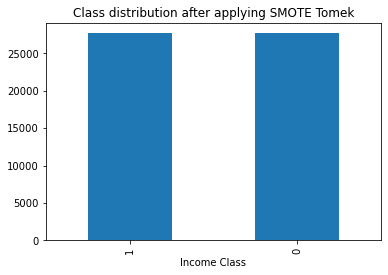

In [10]:
# Complete code for data preperation
# Read data
df_ewd1 = pd.read_csv('adult_ewd1.csv')
#df_ewd1.drop(df_ewd1.columns[0], axis=1, inplace = True)

df_ewd1.rename(columns={'class':'label'}, inplace=True)

disc = 'EWD'
k = 4

df_ewd1.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_ewd1.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ewd1[feat] = le.fit_transform(df_ewd1[feat].astype(str))

print (df_ewd1.info())

data = df_ewd1.values
data.shape

features = df_ewd1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ewd1[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models - EWD, k=4

In [11]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 4'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
obj = sio.dump(model_id3, model_name)

In [12]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 4'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_EWD_4.sav


['adult_CNB_EWD_4.sav']

In [13]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 4'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_EWD_4.skops


## 1.2 EWD, k = 7

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

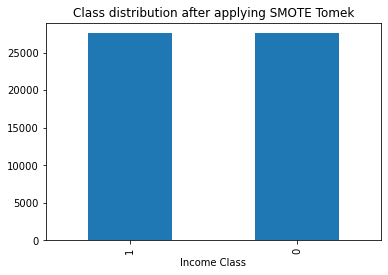

In [14]:
# Complete code for data preperation
# Read data
df_ewd2 = pd.read_csv('adult_ewd2.csv')
df_ewd2.rename(columns={'class':'label'}, inplace=True)

disc = 'EWD'
k = 7

df_ewd2.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_ewd2.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ewd2[feat] = le.fit_transform(df_ewd2[feat].astype(str))

print (df_ewd2.info())

data = df_ewd2.values
data.shape

features = df_ewd2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ewd2[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models - EWD, k=7

In [15]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 7'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_EWD_7.skops


In [16]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 7'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_EWD_7.sav


['adult_CNB_EWD_7.sav']

In [17]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 7'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_EWD_7.skops


## 1.3 EWD, k = 10

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

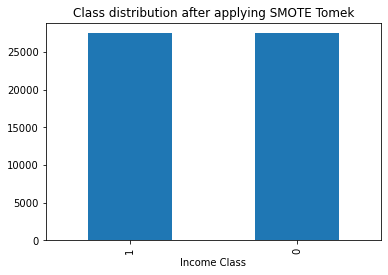

In [18]:
# Complete code for data preperation
# Read data
df_ewd3 = pd.read_csv('adult_ewd3.csv')
df_ewd3.rename(columns={'class':'label'}, inplace=True)

disc = 'EWD'
k = 10

df_ewd3.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_ewd3.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ewd3[feat] = le.fit_transform(df_ewd3[feat].astype(str))

print (df_ewd3.info())

data = df_ewd3.values
data.shape

features = df_ewd3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ewd3[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models - EWD, k=10

In [19]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_EWD_10.skops


In [20]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models

import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_EWD_10.sav


['adult_CNB_EWD_10.sav']

In [21]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'EWD'
disc_param = 'k = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_EWD_10.skops


# 2. EFD datasets

## 2.1 EFD, k = 4

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

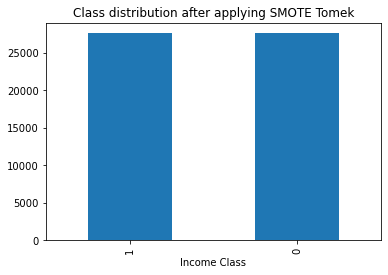

In [22]:
# Complete code for data preperation
# Read data
df_efd1 = pd.read_csv('adult_efd1.csv')
#df_efd1.drop(df_efd1.columns[0], axis=1, inplace = True)

df_efd1.rename(columns={'class':'label'}, inplace=True)

disc = 'EFD'
k = 4

df_efd1.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_efd1.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_efd1[feat] = le.fit_transform(df_efd1[feat].astype(str))

print (df_efd1.info())

data = df_efd1.values
data.shape

features = df_efd1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_efd1[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models - EFD, k=4

In [23]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 4'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_EFD_4.skops


In [24]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 4'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_EFD_4.sav


['adult_CNB_EFD_4.sav']

In [25]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 4'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_EFD_4.skops


## 2.2 EFD, k = 7

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

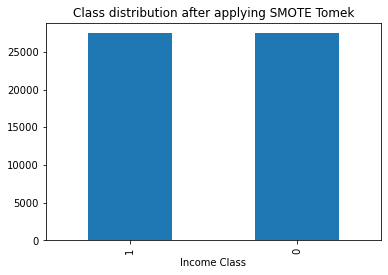

In [26]:
# Complete code for data preperation
# Read data
df_efd2 = pd.read_csv('adult_efd2.csv')
df_efd2.rename(columns={'class':'label'}, inplace=True)

disc = 'EFD'
k = 7

df_efd2.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_efd2.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_efd2[feat] = le.fit_transform(df_efd2[feat].astype(str))

print (df_efd2.info())

data = df_efd2.values
data.shape

features = df_efd2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_efd2[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models, EFD, k=7

In [27]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 7'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_EFD_7.skops


In [28]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 7'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_EFD_7.sav


['adult_CNB_EFD_7.sav']

In [29]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 7'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_EFD_7.skops


## 2.3 EFD, k = 10

### Dataprep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

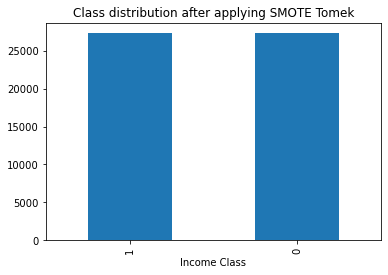

In [30]:
# Complete code for data preperation
# Read data
df_efd3 = pd.read_csv('adult_efd3.csv')
df_efd3.rename(columns={'class':'label'}, inplace=True)

disc = 'EFD'
k = 10

df_efd3.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_efd3.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_efd3[feat] = le.fit_transform(df_efd3[feat].astype(str))

print (df_efd3.info())

data = df_efd3.values
data.shape

features = df_efd3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_efd3[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models, EFD, k=10

In [31]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_EFD_10.skops


In [32]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_EFD_10.sav


['adult_CNB_EFD_10.sav']

In [33]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'EFD'
disc_param = 'k = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_EFD_10.skops


# 3. FFD datasets

## 3.1 FFD, m =10 (tranfusion_ffd1)

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

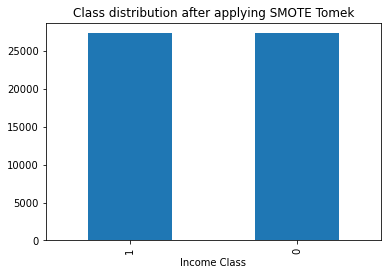

In [34]:
# Complete code for data preperation
# Read data
df_ffd1 = pd.read_csv('adult_ffd1.csv')
df_ffd1.rename(columns={'class':'label'}, inplace=True)

disc = 'FFD'
m = 10

df_ffd1.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_ffd1.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ffd1[feat] = le.fit_transform(df_ffd1[feat].astype(str))

print (df_ffd1.info())

data = df_ffd1.values
data.shape

features = df_ffd1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd1[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models, FFD, m = 10

In [35]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_FFD_10.skops


In [36]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)


adult_CNB_FFD_10.sav


['adult_CNB_FFD_10.sav']

In [37]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 10'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_FFD_10.skops


## 3.1 FFD, m =30 (tranfusion_ffd2)

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

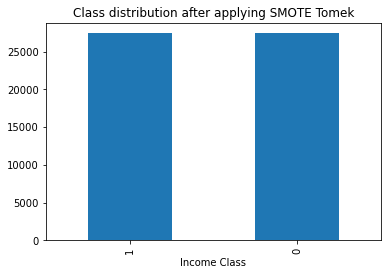

In [38]:
# Complete code for data preperation
# Read data
df_ffd2 = pd.read_csv('adult_ffd2.csv')
#df_ffd2.drop(df_ffd2.columns[0], axis=1, inplace = True)

df_ffd2.rename(columns={'class':'label'}, inplace=True)

disc = 'FFD'
m = 30

df_ffd2.info()

#Label Encoding for object to numeric conversion
objList = df_ffd2.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ffd2[feat] = le.fit_transform(df_ffd2[feat].astype(str))

print (df_ffd2.info())

data = df_ffd2.values
data.shape

features = df_ffd2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd2[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models, FFD, m = 30

In [39]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 30'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_FFD_30.skops


In [40]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 30'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_FFD_30.sav


['adult_CNB_FFD_30.sav']

In [41]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 30'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_FFD_30.skops


## 3.3 FFD, m =60 (tranfusion_ffd3)

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

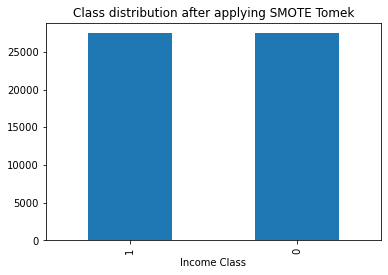

In [42]:
# Complete code for data preperation
# Read data
df_ffd3 = pd.read_csv('adult_ffd3.csv')
#df_ffd3.drop(df_ffd3.columns[0], axis=1, inplace = True)

df_ffd3.rename(columns={'class':'label'}, inplace=True)

disc = 'FFD'
m = 60

df_ffd3.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_ffd3.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ffd3[feat] = le.fit_transform(df_ffd3[feat].astype(str))

print (df_ffd3.info())

data = df_ffd3.values
data.shape

features = df_ffd3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd3[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models, FFD, m = 60

In [43]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 60'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_FFD_60.skops


In [44]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 60'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_FFD_60.sav


['adult_CNB_FFD_60.sav']

In [45]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 60'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_FFD_60.skops


## 3.3 FFD, m =100 (tranfusion_ffd4)

### Data prep

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  label           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB
List of variable for label encoding:  Index(['workclass', 'education', 'marital-status', 'occ

<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Income Class'>

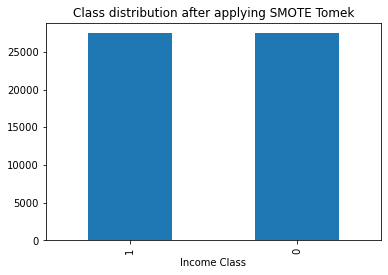

In [46]:
# Complete code for data preperation
# Read data
df_ffd4 = pd.read_csv('adult_ffd4.csv')
#df_ffd4.drop(df_ffd4.columns[0], axis=1, inplace = True)

df_ffd4.rename(columns={'class':'label'}, inplace=True)

disc = 'FFD'
m = 100

df_ffd4.info()

#Label Encoding for object to numeric conversion
#FYI: https://www.kaggle.com/discussions/getting-started/61148
objList = df_ffd4.select_dtypes(include = "object").columns
print('List of variable for label encoding: ', objList)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in objList:
    df_ffd4[feat] = le.fit_transform(df_ffd4[feat].astype(str))

print (df_ffd4.info())

data = df_ffd4.values
data.shape

features = df_ffd4.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_ffd4[features].nunique()

# SMOTE-Tomek
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)

# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Income Class')

### Models, FFD, m = 100

In [47]:
# ID3 - Default
model = 'ID3'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 100'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

adult_ID3_FFD_100.skops


In [48]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 100'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{m}.sav"
print(filename)
joblib.dump(model_nb, filename)

adult_CNB_FFD_100.sav


['adult_CNB_FFD_100.sav']

In [49]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'adult'
discretizer = 'FFD'
disc_param = 'm = 100'

f = open("adult_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, m = {m} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{m}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

adult_KNN-Hamming_FFD_100.skops
